# Getting the data

**Downloading the Data**

The dataset was obtained from Kaggle and can be found here: 
- https://www.kaggle.com/datasets/utkarshsaxenadn/car-vs-bike-classification-dataset/

After downloading the dataset, the folder `Car-Bike-Dataset` has to be placed into the `data`.

# Exploratory Data Analysis on Image-Data

In [2]:
dataset_path = "data/Car-Bike-Dataset"

Load data as dataframe for analysis:

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from skimage import io
import warnings
warnings.simplefilter("ignore", UserWarning)

def data_to_df(data_path):
    """Loads images to dataframe to be used for analysis."""

    class_folders = sorted(os.listdir(data_path))
    n_cls = len(class_folders)

    images = []
    labels = []
    label_mapping = {i: c for i, c in zip(range(n_cls), class_folders)}

    # iterate over all folder
    for i in range(n_cls):
        cls_folder = f"{data_path}/{class_folders[i]}"
        cls_data = sorted(os.listdir(cls_folder))
        
        # Iterate over files in folder
        for img_name in cls_data:
            img_path = os.path.join(cls_folder, img_name)
            img = io.imread(img_path)

            # Checking if erroneous values in read-in image
            if np.isnan(img).any() or np.isinf(img).any():
                print(np.isnan(img).any(), np.isinf(img).any())
            else:
                images.append(img)
                labels.append(i)

    
    df = pd.DataFrame()
    # df['Image_Id'] = [i for i in range(len(images))]
    df['image'] = images
    df['label'] = labels
    return df, label_mapping
        

In [4]:
df, lbl_mapping = data_to_df(dataset_path)
inv_lbl_mapping = {lbl: i for i, lbl in lbl_mapping.items()}
warnings.resetwarnings()

In [5]:
print("Class-mapping: ", lbl_mapping)
print("Inverse Class-mapping:", inv_lbl_mapping)

Class-mapping:  {0: 'Bike', 1: 'Car'}
Inverse Class-mapping: {'Bike': 0, 'Car': 1}


In [6]:
# Peeking into the data
df.head()

,image,label
0,"[[[188, 188, 188], [188, 188, 188], [188, 188,...",0
1,"[[[147, 149, 109], [147, 149, 109], [147, 149,...",0
2,"[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...",0
3,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   4000 non-null   object
 1   label   4000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 62.6+ KB


In [8]:
type(df.iloc[0]["image"]), type(df.iloc[0]["label"])

(numpy.ndarray, numpy.int64)

### Analyzing the image data

**Looking into some images:**

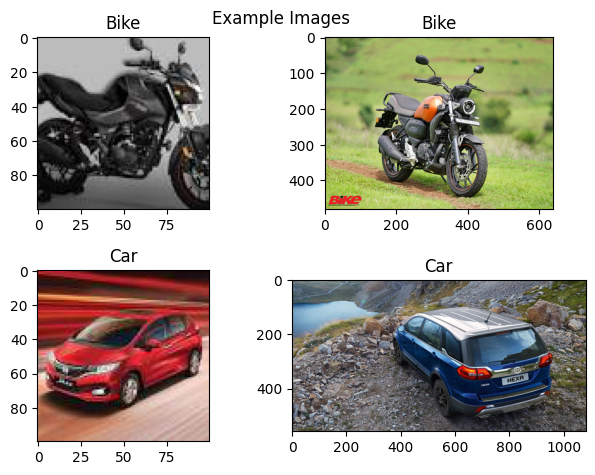

In [9]:
bike_imgs = df[df["label"] == inv_lbl_mapping["Bike"]].iloc[:2]
bike_lbls = list(bike_imgs["label"])
car_imgs = df[df["label"] == inv_lbl_mapping["Car"]].iloc[:2]
car_lbls = list(car_imgs["label"])

bike_img1, bike_img2 = np.array(bike_imgs["image"].iloc[0]), np.array(bike_imgs["image"].iloc[1])
car_img1,  car_img2  = np.array(car_imgs["image"].iloc[0]), np.array(car_imgs["image"].iloc[1])

fig, ax = plt.subplots(2, 2)
ax[0, 0].imshow(bike_img1); ax[0, 0].set_title(f"{lbl_mapping[bike_lbls[0]]}")
ax[0, 1].imshow(bike_img2); ax[0, 1].set_title(f"{lbl_mapping[bike_lbls[1]]}")
ax[1, 0].imshow(car_img1); ax[1, 0].set_title(f"{lbl_mapping[car_lbls[0]]}")
ax[1, 1].imshow(car_img2); ax[1, 1].set_title(f"{lbl_mapping[car_lbls[1]]}")

plt.tight_layout(); plt.suptitle("Example Images")
plt.show()

Now that the dataset is represented as dataframe, it is possible to look into the dataset properties.

**Class-Distribution:**

Classes:  [0 1]
Number of classes:  2


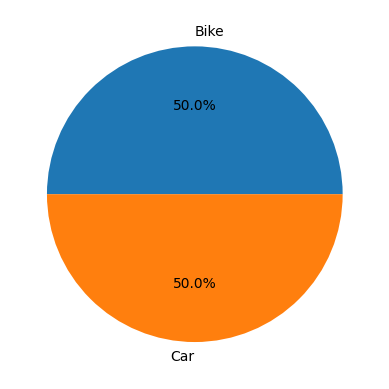

In [10]:
print("Classes: ", df["label"].unique())
print("Number of classes: ", df["label"].nunique())

counts = df["label"].value_counts()
classes = [lbl_mapping[c] for c in list(counts.index)]
plt.pie(counts, labels=classes, autopct="%1.1f%%")
plt.show()

The dataset has an optimal balanced class-distribution, therfore no imblance handling has to be done.

**Color distribution of classes:**

In [11]:
df_eda = pd.DataFrame()
df_eda["label"] = df["label"]
df_eda["label_name"] = df_eda["label"].map(lbl_mapping)

red_channel = df['image'].apply(lambda img: img[:, :, 0])
green_channel = df['image'].apply(lambda img: img[:, :, 1])
blue_channel = df['image'].apply(lambda img: img[:, :, 2])

df_eda['red_channel_avg'] = red_channel.apply(np.mean)
df_eda['green_channel_avg'] = green_channel.apply(np.mean)
df_eda['blue_channel_avg'] = blue_channel.apply(np.mean)

rgb_avg_classes = df_eda.groupby('label_name')[['red_channel_avg', 'green_channel_avg', 'blue_channel_avg']].mean().reset_index()
rgb_avg_classes = rgb_avg_classes.rename(columns={"red_channel_avg": "red", 
                                          "green_channel_avg": "green", 
                                          "blue_channel_avg": "blue",
                                          "label_name": "label"})
rgb_avg_classes

,label,red,green,blue
0,Bike,134.314113,131.835815,129.215071
1,Car,122.800096,120.773252,121.416006


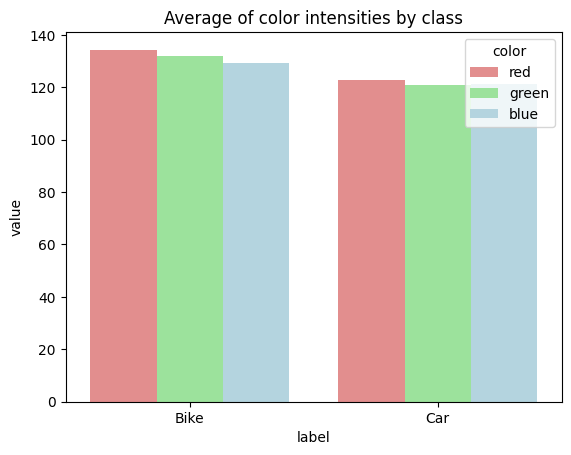

In [12]:
# Plotting the 
colors = ["lightcoral", "lightgreen", "lightblue"]
df_melted = rgb_avg_classes.melt(id_vars='label', var_name='color', value_name='value')
sns.barplot(x='label', y='value', hue='color', data=df_melted, palette=colors)
plt.title('Average of color intensities by class')
plt.show()

Both classes have a relatively similar color distribution. For training, this means that a model can't effectively exploit properties like lighting differences between the classes (bad discriminative feature).

**Size-distribution of classes:**

In [13]:
df_size = pd.DataFrame()
df_size["label_id"] = df["label"]
df_size["label"] = df_size["label_id"].map(lbl_mapping)
df_size["size"] = df["image"].apply(np.size)
df_size["height"] = df["image"].apply(lambda img: img.shape[0])
df_size["width"] = df["image"].apply(lambda img: img.shape[1])
df_size["ratio"] = df_size["width"] / df_size["height"]
df_size

,label_id,label,size,height,width,ratio
0,0,Bike,30000,100,100,1.000000
1,0,Bike,921600,480,640,1.333333
2,0,Bike,690880,340,508,1.494118
3,0,Bike,151074,231,218,0.943723
4,0,Bike,259200,240,360,1.500000
...,...,...,...,...,...,...
3995,1,Car,151200,168,300,1.785714
3996,1,Car,30000,100,100,1.000000
3997,1,Car,150975,183,275,1.502732
3998,1,Car,150804,177,284,1.604520


**Analyzing the size and shape features of the data**:

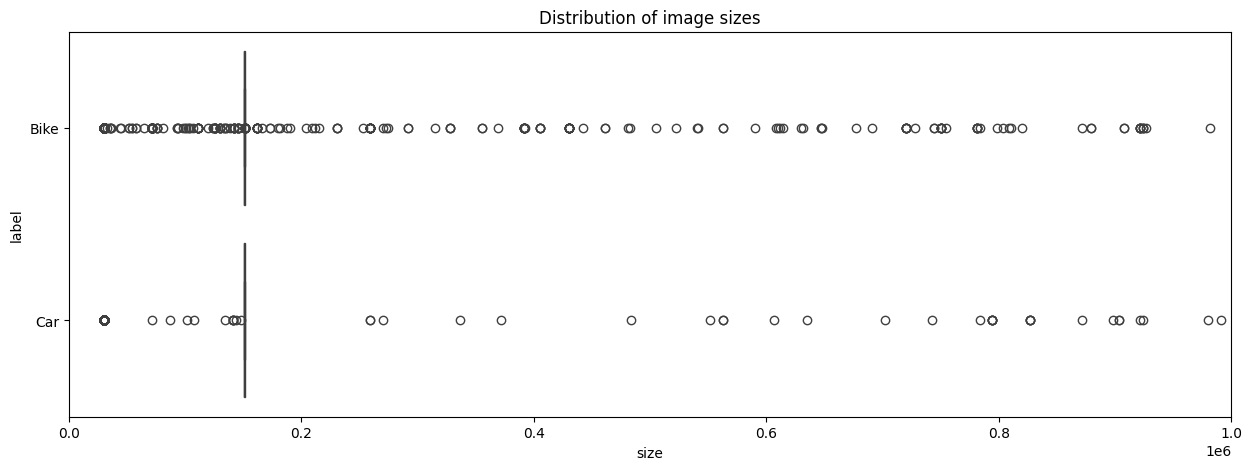

Avg. Car image size:  315256.91
Avg. Bike image size:  462195.27


In [14]:
plt.figure(figsize=(15, 5))
sns.boxplot(data=df_size, x="size", y="label")
plt.title("Distribution of image sizes")
plt.xlim(0, 1e6)
plt.show()

print("Avg. Car image size: ", df_size[df_size["label"] == "Car"]["size"].mean().round(2))
print("Avg. Bike image size: ", df_size[df_size["label"] == "Bike"]["size"].mean().round(2))

Bike images in the dataset are in general somewhat bigger.

**Height- and Width-distribution of the data**

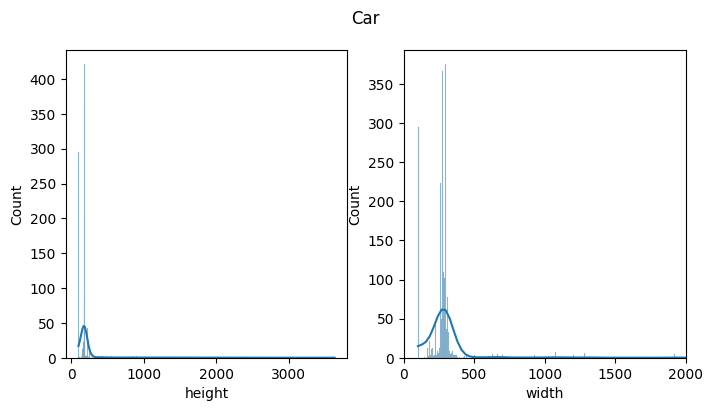

avg height & width of Car img: (193.0, 288.0)


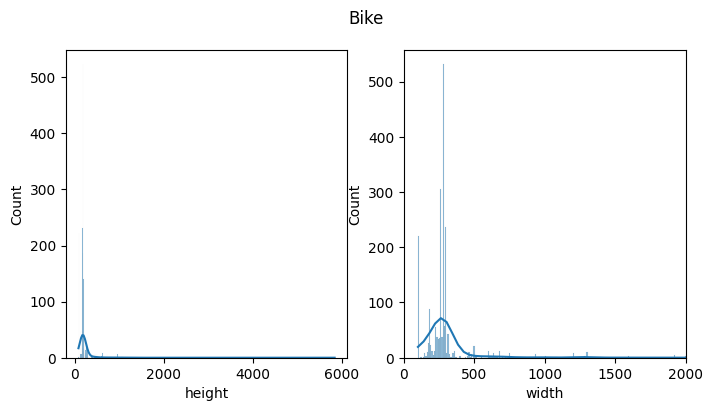

avg height & width of Bike img: (226.0, 307.0)


In [15]:
cars = df_size[df_size["label"] == "Car"]
bikes = df_size[df_size["label"] == "Bike"]

fig1, ax1 = plt.subplots(1, 2, figsize=(8, 4))
sns.histplot(cars["height"], kde=True, ax=ax1[0])
sns.histplot(cars["width"], kde=True, ax=ax1[1])
plt.xlim(0, 2000)
plt.suptitle("Car")
plt.show()
print(f"avg height & width of Car img: ({cars['height'].mean().round(0)}, {cars['width'].mean().round(0)})")


fig2, ax2 = plt.subplots(1, 2, figsize=(8, 4))
sns.histplot(bikes["height"], kde=True, ax=ax2[0])
sns.histplot(bikes["width"], kde=True, ax=ax2[1])
plt.xlim(0, 2000)
plt.suptitle("Bike")
plt.show()
print(f"avg height & width of Bike img: ({bikes['height'].mean().round(0)}, {bikes['width'].mean().round(0)})")


**Checking for huge aspect rations**

In [16]:
len(df_size[(df_size["ratio"] >= 2.0) | df_size["ratio"] <= 0.5])

0

Having a huge aspect ratio could possibly be a suboptimal property of image inputs for machine learning models. This is because pre-processin of image inputs for neural networks will probably distort the aspect ratio relatively heavy in such cases. However there are none of such cases present outside the boundaries of 0.5 and 2.0.

With this the EDA is done and the pre-processing of the data for training will be done.

# Loading the dataset (for training of model)

In [17]:
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms as T
from torch.utils.data import DataLoader, Subset

from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Loading and splitting the data

In [18]:
def train_val_test_split(dataset, train_size, val_size, test_size):
    # Create indices for each split of the original dataset
    train_val_idx, test_idx = train_test_split(np.arange(len(dataset)), test_size=test_size)
    train_idx, val_idx = train_test_split(train_val_idx, test_size=val_size / (train_size + val_size))

    # Create subset based on indices of different 
    train_set = Subset(dataset, train_idx)
    val_set = Subset(dataset, val_idx)
    test_set = Subset(dataset, test_idx)

    return train_set, val_set, test_set

In [19]:
image_size = 224 # required input-size for classification model
batch_size = 64

data_transform = T.Compose([
    T.Lambda(lambda image: image.convert('RGB')),  # Convert to RGB if necessary
    T.Resize((224, 224)),  # Resize to the same size
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225]),  # ImageNet statistics
])

inv_normalize = T.Normalize(mean=[-0.485/0.229,-0.456/0.224,-0.406/0.225],
                            std=[1/0.229,1/0.224,1/0.225])

# Random split train: 60%, val: 20%, test: 20%
dataset = datasets.ImageFolder(dataset_path, transform=data_transform)
splits = { "train_size": 0.6, "val_size": 0.2, "test_size": 0.2 }
train_data, val_data, test_data = train_val_test_split(dataset, **splits)

n_all = len(dataset)
n_train = len(train_data)
n_val = len(val_data)
n_test = len(test_data)

print(f"Train: {(n_train/n_all)*100:.0f}% | #train: {n_train}")
print(f"Val: {(n_val/n_all)*100:.0f}%   | #val: {n_val}")
print(f"Test: {(n_test/n_all)*100:.0f}%  | #test: {n_test}")

# Create dataloader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

Train: 60% | #train: 2400
Val: 20%   | #val: 800
Test: 20%  | #test: 800


Visualizing some data from a dataloader to see if it works

Batch:
images:  torch.Size([64, 3, 224, 224])
labels:  torch.Size([64])
tensor(-2.1179) tensor(2.6400)


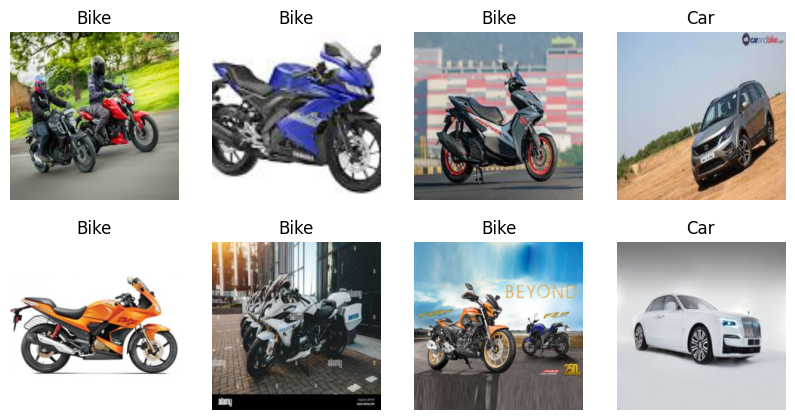

In [20]:
data = next(iter(train_loader))
images, labels = data

print("Batch:")
print("images: ", images.shape)
print("labels: ", labels.shape)
print(images.min(), images.max())

# Parameter to invert the normalization of the input data
normalized = True

fig, ax = plt.subplots(2, 4, figsize=(10, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i, ax in enumerate(ax.flat):
    if normalized:
        image = inv_normalize(images[i].squeeze()).permute(1, 2, 0).numpy()
    else:
        image = images[i].squeeze().permute(1, 2, 0).numpy()

    ax.imshow(image)
    ax.set_title(lbl_mapping[labels[i].item()])
    ax.axis('off')
plt.show()

# Model Definition and Training

In [21]:
class DINOClassifier(nn.Module):
    
    def __init__(self, 
                 model_type="s",
                 hidden_layer_dims=[],
                 use_dropout=False,
                 dropout_prob=0.5,
                 device="cuda"):
        super(DINOClassifier, self).__init__()

        backbone_types = ["s", "b"]
        backbone_out_size = { "s": 384, "b": 768 }
        assert model_type in backbone_types, "Model architecture not available."

        self.model_type = model_type
        self.model_name = f"dino_vit{self.model_type}16"

        self.backbone = torch.hub.load('facebookresearch/dino:main', self.model_name,
                                       force_reload=False).to(device)        

        # Freeze the backbone parameters
        for param in self.backbone.parameters():
            param.requires_grad = False


        # self.use_dropout = use_dropout
        self.dropout_prob = dropout_prob if use_dropout else 0.0

        fc_input_dim = backbone_out_size[model_type]
        self.fc_head = nn.ModuleList()

        for dim in hidden_layer_dims:
            self.fc_head.append(nn.Linear(fc_input_dim, dim))
            fc_input_dim = dim  # Updateing input dimension for the next layer
            self.fc_head.append(nn.Dropout(p=dropout_prob))

        self.fc_head.append(nn.Linear(fc_input_dim, 1))

        self.fc_head = nn.Sequential(*self.fc_head)

        self.fc_head.to(device)

    def forward(self, x):
        # Getting features from ViT-Backbone
        features = self.backbone(x)

        # Processing the features in the fully connected classification head
        feature_input = features.view(features.size(0), -1)

        for layer in self.fc_head[:-1]:  # Exclude the last layer
            feature_input = layer(feature_input)
            if isinstance(layer, nn.Linear):
                feature_input = F.relu(feature_input)

        # Apply sigmoid activation directly on the final layer's output
        out = torch.sigmoid(self.fc_head[-1](feature_input))

        return out, features

Training-Code:

In [22]:
def accuracy_fn(outputs, labels):
    pred = torch.round(outputs)
    correc_pred = (pred == labels).sum().float()
    acc = correc_pred / len(outputs)
    return acc

def train(model, optimizer,loss_fn, n_epochs, train_loader, val_loader):

    history = {
        'loss': [], 
        'val_loss': [], 
        'accuracy': [], 
        'val_accuracy': []
    }

    for epoch in range(n_epochs):
        train_loss = 0.0
        val_loss = 0.0
        train_accuracy = 0.0
        val_accuracy = 0.0

        # Training-loop
        model.train()
        for data in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{n_epochs} [Training]"):
            # Getting the Image(s) and label(s)
            inputs, labels = data

            # Put data to gpu (if available)
            inputs = inputs.to(device)
            labels = labels.float().to(device)

            # Set all accumulated grad's to 0 to start new backprop
            outputs, _ = model(inputs)      
            outputs = outputs.squeeze()

            # Compute Loss
            loss = loss_fn(outputs, labels)

            # Perform optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # print(loss)
            train_loss += loss.item()
            train_accuracy += accuracy_fn(outputs, labels).item()

        # Validation-loop
        model.eval()
        with torch.no_grad():
            for data in tqdm(val_loader, desc=f"Epoch {epoch + 1}/{n_epochs} [Validation]"):
                inputs, labels = data

                inputs = inputs.to(device)
                labels = labels.float().to(device)
                
                outputs, _ = model(inputs)
                outputs = outputs.squeeze()

                loss = loss_fn(outputs, labels)

                val_loss += loss.item()
                val_accuracy += accuracy_fn(outputs, labels).item()

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_accuracy /= len(train_loader)
        val_accuracy /= len(val_loader)
    
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)

        print(f"loss: {train_loss:.4f} - accuracy: {train_accuracy:.4f} - val_loss: {val_loss:.4f} - val_accuracy: {val_accuracy:.4f}")

    return history

def eval(model, loss_fn, n_epochs, test_loader):
    history = {
        'loss': [], 
        'accuracy': []
    }

    test_loss = 0.0
    test_accuracy = 0.0

    # Validation-loop
    model.eval()
    with torch.no_grad():
        for data in tqdm(test_loader, desc=f"[Test]"):
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.float().to(device)
            
            outputs, _ = model(inputs)
            outputs = outputs.squeeze()

            loss = loss_fn(outputs, labels)

            test_loss += loss.item()
            test_accuracy += accuracy_fn(outputs, labels).item()

    test_loss /= len(test_loader)
    test_accuracy /= len(test_loader)

    history['loss'].append(test_loss)
    history['accuracy'].append(test_accuracy)

    print(f"loss: {test_loss:.4f} - accuracy: {test_accuracy:.4f}")

    return history    


**Model-Training:**

In [23]:
import torch.optim as optim

In [24]:
model_cfg = {
    "model_type": "s",
    "hidden_layer_dims": [],
    "use_dropout": False,
    "dropout_prob": 0.5,
}

In [25]:
model = DINOClassifier(**model_cfg).to(device)
print(model)

Using cache found in /home/user22/.cache/torch/hub/facebookresearch_dino_main


DINOClassifier(
  (backbone): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm): L

**Training-Test**: to see if it works, before going to a more systematic approach for hyperparameter optimization.

In [27]:
learning_rate = 0.002
momentum = 0.8
batch_size = 64
n_epochs = 5

# Binary Cross-Entropy loss
loss_fn = nn.BCELoss()
# SGD-optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [28]:
# Create dataloader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [29]:
import time

In [30]:
t0 = time.time()
history = train(
    model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    n_epochs=n_epochs,
    train_loader=train_loader,
    val_loader=val_loader
)
dt = time.time() - t0
print(f"Training-Time: {round(dt, 1)} s")

Epoch 1/5 [Training]:  34%|███▍      | 13/38 [00:05<00:08,  2.95it/s]/home/user22/miniconda3/envs/dev-env-gpu/lib/python3.9/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.57it/s]


loss: 0.1594 - accuracy: 0.9556 - val_loss: 0.0286 - val_accuracy: 0.9928


Epoch 2/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.60it/s]


loss: 0.0242 - accuracy: 0.9934 - val_loss: 0.0249 - val_accuracy: 0.9928


Epoch 3/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.46it/s]


loss: 0.0185 - accuracy: 0.9951 - val_loss: 0.0293 - val_accuracy: 0.9916


Epoch 4/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.60it/s]


loss: 0.0152 - accuracy: 0.9955 - val_loss: 0.0287 - val_accuracy: 0.9928


Epoch 5/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.63it/s]

loss: 0.0112 - accuracy: 0.9971 - val_loss: 0.0307 - val_accuracy: 0.9916
Training-Time: 81.7 s


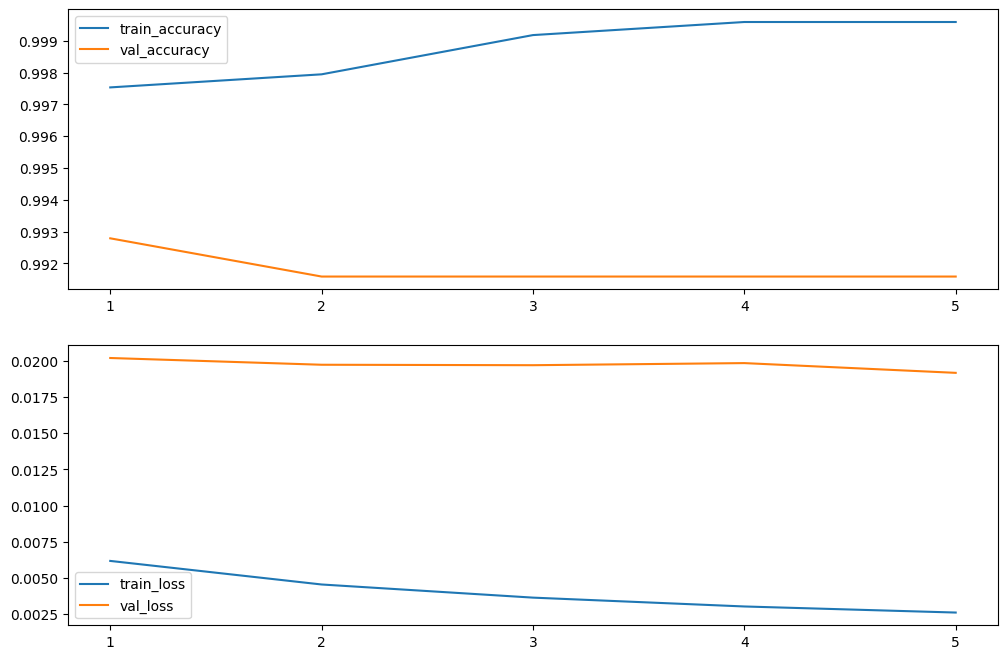

In [81]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

epochs = np.arange(1, n_epochs + 1)

ax[0].plot(epochs, history["accuracy"], label="train_accuracy")
ax[0].plot(epochs, history["val_accuracy"], label="val_accuracy")
ax[0].set_xticks(epochs)
ax[0].legend()
ax[1].plot(epochs, history["loss"], label="train_loss")
ax[1].plot(epochs, history["val_loss"], label="val_loss")
ax[1].set_xticks(epochs)
ax[1].legend()
plt.show()

Even though the lines seem to diverge, the scale of divergence is very small. The overall performance of the model seems to be really good, even for few training-epochs.

## Hyperparameter Optimization with Optuna

In this section optuna is used for hyperparameter tuning of:
- `use_dropout`: Usage of dropout (`True`, `False`)
- `dropout_rate`: Probability of dropout (`p from [0.0, 0.2, 0.5]`)
- `learning_rate`: step-size for training (log-distributed between 1e-5 and 1e-1)
- `hidden_layer_dims`: number of neurons in hidden layer (`[64, 128, 256, 512]`)

In [31]:
# Install optuna for hyperparameter tuning
# !pip install optuna -qq

In [32]:
import optuna

In [33]:
def objective(trial):
    # Define the search space for hyperparameters
    use_dropout = trial.suggest_categorical('use_dropout', [True, False])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.0, 0.2, 0.5])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    hidden_layer_dims = trial.suggest_categorical('hidden_layer_dims', [2**p for p in range(6, 10)])

    model_cfg = {
        "model_type": "s",
        "hidden_layer_dims": [hidden_layer_dims],
        "use_dropout": use_dropout,
        "dropout_prob": dropout_rate,
    }

    model = DINOClassifier(**model_cfg).to(device)
 
    trial.set_user_attr("momentum", 0.8)
    trial.set_user_attr("batch_size", 64)
    trial.set_user_attr("n_epochs", 5)

    # Create dataloader
    train_loader = DataLoader(train_data, batch_size=trial.user_attrs["batch_size"], shuffle=True)
    val_loader = DataLoader(val_data, batch_size=trial.user_attrs["batch_size"], shuffle=True)

    # Binary Cross-Entropy loss
    loss_fn = nn.BCELoss()
    # SGD-optimizer
    # optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=trial.user_attrs["momentum"])

    history = train(
        model,
        optimizer=optimizer,
        loss_fn=loss_fn,
        n_epochs=trial.user_attrs["n_epochs"],
        train_loader=train_loader,
        val_loader=val_loader
    )
    
    train_loss = history['loss'][-1]
    val_loss = history['val_loss'][-1]
    train_accuracy = history["accuracy"][-1]
    val_accuracy = history['val_accuracy'][-1]

    obj = (train_accuracy - train_loss) + (val_accuracy - val_loss)

    return obj

Since the first training epoch yielded exceptional results, only a few other options are tested:

In [83]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2023-12-16 23:36:01,809] A new study created in memory with name: no-name-7602b9e8-8b43-4373-a404-2eb08db70369
/tmp/ipykernel_45133/1202816740.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
Using cache found in /home/user22/.cache/torch/hub/facebookresearch_dino_main
Epoch 1/5 [Training]:  68%|██████▊   | 26/38 [00:09<00:03,  3.07it/s]/home/user22/miniconda3/envs/dev-env/lib/python3.9/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  2.80it/s]


loss: 0.1098 - accuracy: 0.9659 - val_loss: 0.0361 - val_accuracy: 0.9880


Epoch 2/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  3.00it/s]


loss: 0.0245 - accuracy: 0.9951 - val_loss: 0.0267 - val_accuracy: 0.9928


Epoch 3/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


loss: 0.0202 - accuracy: 0.9947 - val_loss: 0.0249 - val_accuracy: 0.9940


Epoch 4/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  2.75it/s]


loss: 0.0176 - accuracy: 0.9959 - val_loss: 0.0238 - val_accuracy: 0.9940


Epoch 5/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  2.91it/s]
[I 2023-12-16 23:37:39,168] Trial 0 finished with value: 1.9517377769915756 and parameters: {'use_dropout': False, 'dropout_rate': 0.0, 'learning_rate': 0.001777300322140305, 'hidden_layer_dims': 64}. Best is trial 0 with value: 1.9517377769915756.
Using cache found in /home/user22/.cache/torch/hub/facebookresearch_dino_main


loss: 0.0158 - accuracy: 0.9967 - val_loss: 0.0231 - val_accuracy: 0.9940


Epoch 1/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.43it/s]


loss: 0.1347 - accuracy: 0.9453 - val_loss: 0.0264 - val_accuracy: 0.9928


Epoch 2/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  3.07it/s]


loss: 0.0315 - accuracy: 0.9905 - val_loss: 0.0220 - val_accuracy: 0.9940


Epoch 3/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.52it/s]


loss: 0.0253 - accuracy: 0.9922 - val_loss: 0.0196 - val_accuracy: 0.9952


Epoch 4/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  3.07it/s]


loss: 0.0218 - accuracy: 0.9934 - val_loss: 0.0176 - val_accuracy: 0.9952


Epoch 5/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.36it/s]
[I 2023-12-16 23:38:59,808] Trial 1 finished with value: 1.9560040971132273 and parameters: {'use_dropout': True, 'dropout_rate': 0.2, 'learning_rate': 0.0019673286675018315, 'hidden_layer_dims': 128}. Best is trial 1 with value: 1.9560040971132273.
Using cache found in /home/user22/.cache/torch/hub/facebookresearch_dino_main


loss: 0.0176 - accuracy: 0.9955 - val_loss: 0.0170 - val_accuracy: 0.9952


Epoch 1/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  3.10it/s]


loss: 0.1502 - accuracy: 0.9741 - val_loss: 0.0354 - val_accuracy: 0.9904


Epoch 2/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


loss: 0.0593 - accuracy: 0.9951 - val_loss: 0.0310 - val_accuracy: 0.9916


Epoch 3/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  3.02it/s]


loss: 0.0502 - accuracy: 0.9963 - val_loss: 0.0400 - val_accuracy: 0.9892


Epoch 4/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  3.01it/s]


loss: 0.0113 - accuracy: 0.9975 - val_loss: 0.0302 - val_accuracy: 0.9892


Epoch 5/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.50it/s]
[I 2023-12-16 23:40:21,219] Trial 2 finished with value: 1.9660469505077267 and parameters: {'use_dropout': False, 'dropout_rate': 0.5, 'learning_rate': 0.04443759640383487, 'hidden_layer_dims': 128}. Best is trial 2 with value: 1.9660469505077267.
Using cache found in /home/user22/.cache/torch/hub/facebookresearch_dino_main


loss: 0.0046 - accuracy: 0.9988 - val_loss: 0.0221 - val_accuracy: 0.9940


Epoch 1/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  2.95it/s]


loss: 0.1013 - accuracy: 0.9548 - val_loss: 0.0222 - val_accuracy: 0.9904


Epoch 2/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.40it/s]


loss: 0.0183 - accuracy: 0.9951 - val_loss: 0.0220 - val_accuracy: 0.9904


Epoch 3/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  3.03it/s]


loss: 0.0127 - accuracy: 0.9959 - val_loss: 0.0220 - val_accuracy: 0.9916


Epoch 4/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.53it/s]


loss: 0.0119 - accuracy: 0.9971 - val_loss: 0.0226 - val_accuracy: 0.9904


Epoch 5/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  3.09it/s]
[I 2023-12-16 23:41:42,144] Trial 3 finished with value: 1.9606157846118206 and parameters: {'use_dropout': True, 'dropout_rate': 0.2, 'learning_rate': 0.0032494131003808877, 'hidden_layer_dims': 256}. Best is trial 2 with value: 1.9660469505077267.
Using cache found in /home/user22/.cache/torch/hub/facebookresearch_dino_main


loss: 0.0111 - accuracy: 0.9971 - val_loss: 0.0182 - val_accuracy: 0.9928


Epoch 1/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.37it/s]


loss: 0.1197 - accuracy: 0.9576 - val_loss: 0.0301 - val_accuracy: 0.9916


Epoch 2/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


loss: 0.0305 - accuracy: 0.9930 - val_loss: 0.0227 - val_accuracy: 0.9940


Epoch 3/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  3.00it/s]


loss: 0.0220 - accuracy: 0.9951 - val_loss: 0.0219 - val_accuracy: 0.9940


Epoch 4/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


loss: 0.0202 - accuracy: 0.9942 - val_loss: 0.0190 - val_accuracy: 0.9940


Epoch 5/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  3.24it/s]
[I 2023-12-16 23:43:02,073] Trial 4 finished with value: 1.948241718439574 and parameters: {'use_dropout': True, 'dropout_rate': 0.2, 'learning_rate': 0.001013692018220172, 'hidden_layer_dims': 512}. Best is trial 2 with value: 1.9660469505077267.
Using cache found in /home/user22/.cache/torch/hub/facebookresearch_dino_main


loss: 0.0195 - accuracy: 0.9951 - val_loss: 0.0202 - val_accuracy: 0.9928


Epoch 1/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.51it/s]


loss: 0.0565 - accuracy: 0.9745 - val_loss: 0.0233 - val_accuracy: 0.9904


Epoch 2/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  2.97it/s]


loss: 0.0106 - accuracy: 0.9979 - val_loss: 0.0343 - val_accuracy: 0.9892


Epoch 3/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.44it/s]


loss: 0.0071 - accuracy: 0.9984 - val_loss: 0.0214 - val_accuracy: 0.9940


Epoch 4/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  2.98it/s]


loss: 0.0030 - accuracy: 0.9996 - val_loss: 0.0174 - val_accuracy: 0.9928


Epoch 5/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.49it/s]
[I 2023-12-16 23:44:21,885] Trial 5 finished with value: 1.9659814022081028 and parameters: {'use_dropout': True, 'dropout_rate': 0.2, 'learning_rate': 0.015945404728819848, 'hidden_layer_dims': 256}. Best is trial 2 with value: 1.9660469505077267.
Using cache found in /home/user22/.cache/torch/hub/facebookresearch_dino_main


loss: 0.0021 - accuracy: 0.9996 - val_loss: 0.0219 - val_accuracy: 0.9904


Epoch 1/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  3.06it/s]


loss: 0.3065 - accuracy: 0.8635 - val_loss: 0.0802 - val_accuracy: 0.9820


Epoch 2/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.29it/s]


loss: 0.0928 - accuracy: 0.9774 - val_loss: 0.0498 - val_accuracy: 0.9880


Epoch 3/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  2.96it/s]


loss: 0.0659 - accuracy: 0.9844 - val_loss: 0.0393 - val_accuracy: 0.9868


Epoch 4/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  2.84it/s]


loss: 0.0536 - accuracy: 0.9881 - val_loss: 0.0326 - val_accuracy: 0.9880


Epoch 5/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  3.12it/s]
[I 2023-12-16 23:45:43,379] Trial 6 finished with value: 1.9025873235626682 and parameters: {'use_dropout': True, 'dropout_rate': 0.5, 'learning_rate': 0.0004218818895101032, 'hidden_layer_dims': 128}. Best is trial 2 with value: 1.9660469505077267.
Using cache found in /home/user22/.cache/torch/hub/facebookresearch_dino_main


loss: 0.0449 - accuracy: 0.9893 - val_loss: 0.0298 - val_accuracy: 0.9880


Epoch 1/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


loss: 0.2176 - accuracy: 0.8997 - val_loss: 0.0562 - val_accuracy: 0.9880


Epoch 2/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.63it/s]


loss: 0.0505 - accuracy: 0.9897 - val_loss: 0.0399 - val_accuracy: 0.9928


Epoch 3/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.50it/s]


loss: 0.0382 - accuracy: 0.9918 - val_loss: 0.0344 - val_accuracy: 0.9928


Epoch 4/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.29it/s]


loss: 0.0316 - accuracy: 0.9926 - val_loss: 0.0310 - val_accuracy: 0.9928


Epoch 5/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.73it/s]
[I 2023-12-16 23:47:00,449] Trial 7 finished with value: 1.9263956255613173 and parameters: {'use_dropout': False, 'dropout_rate': 0.2, 'learning_rate': 0.0005127011157628073, 'hidden_layer_dims': 256}. Best is trial 2 with value: 1.9660469505077267.
Using cache found in /home/user22/.cache/torch/hub/facebookresearch_dino_main


loss: 0.0291 - accuracy: 0.9914 - val_loss: 0.0287 - val_accuracy: 0.9928


Epoch 1/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


loss: 0.9013 - accuracy: 0.9531 - val_loss: 0.9532 - val_accuracy: 0.9880


Epoch 2/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.71it/s]


loss: 0.5171 - accuracy: 0.9926 - val_loss: 0.7246 - val_accuracy: 0.9916


Epoch 3/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.81it/s]


loss: 0.6193 - accuracy: 0.9930 - val_loss: 0.6165 - val_accuracy: 0.9916


Epoch 4/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


loss: 0.2392 - accuracy: 0.9959 - val_loss: 0.5324 - val_accuracy: 0.9928


Epoch 5/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.77it/s]
[I 2023-12-16 23:48:15,039] Trial 8 finished with value: 1.4421315496474731 and parameters: {'use_dropout': False, 'dropout_rate': 0.2, 'learning_rate': 0.06565398226312347, 'hidden_layer_dims': 256}. Best is trial 2 with value: 1.9660469505077267.
Using cache found in /home/user22/.cache/torch/hub/facebookresearch_dino_main


loss: 0.2259 - accuracy: 0.9955 - val_loss: 0.3227 - val_accuracy: 0.9952


Epoch 1/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  3.17it/s]


loss: 0.0513 - accuracy: 0.9790 - val_loss: 0.0209 - val_accuracy: 0.9928


Epoch 2/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.37it/s]


loss: 0.0098 - accuracy: 0.9967 - val_loss: 0.0190 - val_accuracy: 0.9940


Epoch 3/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.74it/s]


loss: 0.0039 - accuracy: 0.9992 - val_loss: 0.0201 - val_accuracy: 0.9940


Epoch 4/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


loss: 0.0019 - accuracy: 0.9996 - val_loss: 0.0200 - val_accuracy: 0.9940


Epoch 5/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.62it/s]
[I 2023-12-16 23:49:30,203] Trial 9 finished with value: 1.971495505129894 and parameters: {'use_dropout': False, 'dropout_rate': 0.0, 'learning_rate': 0.028479776714071592, 'hidden_layer_dims': 64}. Best is trial 9 with value: 1.971495505129894.
Using cache found in /home/user22/.cache/torch/hub/facebookresearch_dino_main


loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.0214 - val_accuracy: 0.9940


Epoch 1/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.27it/s]


loss: 0.9461 - accuracy: 0.3635 - val_loss: 0.7382 - val_accuracy: 0.4964


Epoch 2/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  3.19it/s]


loss: 0.5768 - accuracy: 0.7002 - val_loss: 0.4798 - val_accuracy: 0.8233


Epoch 3/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.76it/s]


loss: 0.3954 - accuracy: 0.9046 - val_loss: 0.3493 - val_accuracy: 0.9171


Epoch 4/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  3.21it/s]


loss: 0.2968 - accuracy: 0.9515 - val_loss: 0.2714 - val_accuracy: 0.9471


Epoch 5/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  3.15it/s]
[I 2023-12-16 23:50:45,344] Trial 10 finished with value: 1.4661676542237703 and parameters: {'use_dropout': False, 'dropout_rate': 0.0, 'learning_rate': 3.108616741541912e-05, 'hidden_layer_dims': 64}. Best is trial 9 with value: 1.971495505129894.
Using cache found in /home/user22/.cache/torch/hub/facebookresearch_dino_main


loss: 0.2382 - accuracy: 0.9675 - val_loss: 0.2258 - val_accuracy: 0.9627


Epoch 1/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.72it/s]


loss: 0.1727 - accuracy: 0.9704 - val_loss: 0.0594 - val_accuracy: 0.9916


Epoch 2/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.25it/s]


loss: 0.1044 - accuracy: 0.9938 - val_loss: 0.0406 - val_accuracy: 0.9940


Epoch 3/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.54it/s]


loss: 0.1339 - accuracy: 0.9959 - val_loss: 0.0367 - val_accuracy: 0.9940


Epoch 4/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.60it/s]


loss: 0.0845 - accuracy: 0.9988 - val_loss: 0.0338 - val_accuracy: 0.9940


Epoch 5/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.26it/s]
[I 2023-12-16 23:52:00,377] Trial 11 finished with value: 1.8725641650801443 and parameters: {'use_dropout': False, 'dropout_rate': 0.5, 'learning_rate': 0.05902609075495432, 'hidden_layer_dims': 128}. Best is trial 9 with value: 1.971495505129894.
Using cache found in /home/user22/.cache/torch/hub/facebookresearch_dino_main


loss: 0.0831 - accuracy: 0.9988 - val_loss: 0.0383 - val_accuracy: 0.9952


Epoch 1/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.79it/s]


loss: 0.0719 - accuracy: 0.9696 - val_loss: 0.0186 - val_accuracy: 0.9928


Epoch 2/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.28it/s]


loss: 0.0189 - accuracy: 0.9951 - val_loss: 0.0172 - val_accuracy: 0.9940


Epoch 3/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


loss: 0.0117 - accuracy: 0.9967 - val_loss: 0.0164 - val_accuracy: 0.9940


Epoch 4/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.72it/s]


loss: 0.0079 - accuracy: 0.9971 - val_loss: 0.0247 - val_accuracy: 0.9916


Epoch 5/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.27it/s]
[I 2023-12-16 23:53:15,310] Trial 12 finished with value: 1.9667493201261266 and parameters: {'use_dropout': False, 'dropout_rate': 0.5, 'learning_rate': 0.015702270164686657, 'hidden_layer_dims': 64}. Best is trial 9 with value: 1.971495505129894.
Using cache found in /home/user22/.cache/torch/hub/facebookresearch_dino_main


loss: 0.0062 - accuracy: 0.9984 - val_loss: 0.0182 - val_accuracy: 0.9928


Epoch 1/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


loss: 0.0604 - accuracy: 0.9720 - val_loss: 0.0171 - val_accuracy: 0.9928


Epoch 2/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.45it/s]


loss: 0.0121 - accuracy: 0.9971 - val_loss: 0.0165 - val_accuracy: 0.9904


Epoch 3/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  3.04it/s]


loss: 0.0083 - accuracy: 0.9984 - val_loss: 0.0164 - val_accuracy: 0.9928


Epoch 4/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.76it/s]


loss: 0.0054 - accuracy: 0.9988 - val_loss: 0.0155 - val_accuracy: 0.9940


Epoch 5/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.27it/s]
[I 2023-12-16 23:54:31,218] Trial 13 finished with value: 1.9714707719107138 and parameters: {'use_dropout': False, 'dropout_rate': 0.0, 'learning_rate': 0.010938943998646597, 'hidden_layer_dims': 64}. Best is trial 9 with value: 1.971495505129894.
Using cache found in /home/user22/.cache/torch/hub/facebookresearch_dino_main


loss: 0.0036 - accuracy: 0.9988 - val_loss: 0.0153 - val_accuracy: 0.9916


Epoch 1/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  3.09it/s]


loss: 0.0660 - accuracy: 0.9737 - val_loss: 0.0173 - val_accuracy: 0.9928


Epoch 2/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.59it/s]


loss: 0.0144 - accuracy: 0.9963 - val_loss: 0.0186 - val_accuracy: 0.9916


Epoch 3/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  3.24it/s]


loss: 0.0100 - accuracy: 0.9975 - val_loss: 0.0159 - val_accuracy: 0.9928


Epoch 4/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.71it/s]


loss: 0.0071 - accuracy: 0.9979 - val_loss: 0.0170 - val_accuracy: 0.9916


Epoch 5/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  3.24it/s]
[I 2023-12-16 23:55:46,357] Trial 14 finished with value: 1.9707842442442225 and parameters: {'use_dropout': False, 'dropout_rate': 0.0, 'learning_rate': 0.008962704810188765, 'hidden_layer_dims': 64}. Best is trial 9 with value: 1.971495505129894.
Using cache found in /home/user22/.cache/torch/hub/facebookresearch_dino_main


loss: 0.0055 - accuracy: 0.9988 - val_loss: 0.0165 - val_accuracy: 0.9940


Epoch 1/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  3.13it/s]


loss: 0.0612 - accuracy: 0.9786 - val_loss: 0.0161 - val_accuracy: 0.9952


Epoch 2/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.78it/s]


loss: 0.0161 - accuracy: 0.9951 - val_loss: 0.0158 - val_accuracy: 0.9940


Epoch 3/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.38it/s]


loss: 0.0109 - accuracy: 0.9979 - val_loss: 0.0147 - val_accuracy: 0.9952


Epoch 4/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.43it/s]


loss: 0.0082 - accuracy: 0.9984 - val_loss: 0.0147 - val_accuracy: 0.9952


Epoch 5/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.50it/s]
[I 2023-12-16 23:57:01,104] Trial 15 finished with value: 1.9722135840737929 and parameters: {'use_dropout': False, 'dropout_rate': 0.0, 'learning_rate': 0.007262717757314849, 'hidden_layer_dims': 64}. Best is trial 15 with value: 1.9722135840737929.
Using cache found in /home/user22/.cache/torch/hub/facebookresearch_dino_main


loss: 0.0066 - accuracy: 0.9984 - val_loss: 0.0147 - val_accuracy: 0.9952


Epoch 1/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.42it/s]


loss: 0.0818 - accuracy: 0.9675 - val_loss: 0.0196 - val_accuracy: 0.9916


Epoch 2/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.66it/s]


loss: 0.0134 - accuracy: 0.9959 - val_loss: 0.0195 - val_accuracy: 0.9928


Epoch 3/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


loss: 0.0094 - accuracy: 0.9984 - val_loss: 0.0179 - val_accuracy: 0.9940


Epoch 4/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.30it/s]


loss: 0.0061 - accuracy: 0.9988 - val_loss: 0.0183 - val_accuracy: 0.9928


Epoch 5/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.77it/s]
[I 2023-12-16 23:58:16,328] Trial 16 finished with value: 1.9707547622685435 and parameters: {'use_dropout': False, 'dropout_rate': 0.0, 'learning_rate': 0.005525839135997863, 'hidden_layer_dims': 512}. Best is trial 15 with value: 1.9722135840737929.
Using cache found in /home/user22/.cache/torch/hub/facebookresearch_dino_main


loss: 0.0046 - accuracy: 0.9992 - val_loss: 0.0179 - val_accuracy: 0.9940


Epoch 1/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  3.16it/s]


loss: 0.0423 - accuracy: 0.9868 - val_loss: 0.0350 - val_accuracy: 0.9916


Epoch 2/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.79it/s]


loss: 0.0066 - accuracy: 0.9975 - val_loss: 0.0271 - val_accuracy: 0.9916


Epoch 3/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.43it/s]


loss: 0.0020 - accuracy: 0.9996 - val_loss: 0.0236 - val_accuracy: 0.9928


Epoch 4/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.33it/s]


loss: 0.0007 - accuracy: 1.0000 - val_loss: 0.0247 - val_accuracy: 0.9928


Epoch 5/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.70it/s]
[I 2023-12-16 23:59:31,045] Trial 17 finished with value: 1.9683705620069234 and parameters: {'use_dropout': False, 'dropout_rate': 0.0, 'learning_rate': 0.030660123171312673, 'hidden_layer_dims': 64}. Best is trial 15 with value: 1.9722135840737929.
Using cache found in /home/user22/.cache/torch/hub/facebookresearch_dino_main


loss: 0.0005 - accuracy: 1.0000 - val_loss: 0.0252 - val_accuracy: 0.9940


Epoch 1/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  3.23it/s]


loss: 0.1981 - accuracy: 0.9770 - val_loss: 0.1655 - val_accuracy: 0.9904


Epoch 2/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.29it/s]


loss: 0.1393 - accuracy: 0.9963 - val_loss: 0.0472 - val_accuracy: 0.9928


Epoch 3/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.72it/s]


loss: 0.0829 - accuracy: 0.9988 - val_loss: 0.0493 - val_accuracy: 0.9916


Epoch 4/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


loss: 0.1236 - accuracy: 0.9988 - val_loss: 0.0442 - val_accuracy: 0.9964


Epoch 5/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.62it/s]
[I 2023-12-17 00:00:46,915] Trial 18 finished with value: 1.8486964191155961 and parameters: {'use_dropout': False, 'dropout_rate': 0.0, 'learning_rate': 0.09229446979854536, 'hidden_layer_dims': 64}. Best is trial 15 with value: 1.9722135840737929.
Using cache found in /home/user22/.cache/torch/hub/facebookresearch_dino_main


loss: 0.0823 - accuracy: 0.9992 - val_loss: 0.0634 - val_accuracy: 0.9952


Epoch 1/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.29it/s]


loss: 0.0459 - accuracy: 0.9819 - val_loss: 0.0255 - val_accuracy: 0.9928


Epoch 2/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.26it/s]


loss: 0.0078 - accuracy: 0.9979 - val_loss: 0.0229 - val_accuracy: 0.9928


Epoch 3/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.69it/s]


loss: 0.0024 - accuracy: 0.9996 - val_loss: 0.0224 - val_accuracy: 0.9928


Epoch 4/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.34it/s]


loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0227 - val_accuracy: 0.9952


Epoch 5/5 [Validation]: 100%|██████████| 13/13 [00:03<00:00,  3.61it/s]
[I 2023-12-17 00:02:01,773] Trial 19 finished with value: 1.969763304268019 and parameters: {'use_dropout': False, 'dropout_rate': 0.0, 'learning_rate': 0.02653852935404658, 'hidden_layer_dims': 64}. Best is trial 15 with value: 1.9722135840737929.


loss: 0.0009 - accuracy: 1.0000 - val_loss: 0.0234 - val_accuracy: 0.9940


**Choosing best parameter from hyperparameter-tuning**:

It would be possible to test out more parameters, but apparently the current model is already sufficiently good. Therefore the paramteters will be used to train the final model and to evaluate it on the test-set.

In [86]:
best_obj = study.best_value
best_params = study.best_params

print("Best Objective: ", best_obj)
print("Best Parameters:", best_params)

Best Objective:  1.9722135840737929
Best Parameters: {'use_dropout': False, 'dropout_rate': 0.0, 'learning_rate': 0.007262717757314849, 'hidden_layer_dims': 64}


**Training the final model**

In [ ]:
# Defining the final model
params_final = {
    "model_type": "s",
    "hidden_layer_dims": [best_params["hidden_layer_dims"]],
    "use_dropout": best_params["use_dropout"],
    "dropout_prob": best_params["dropout_rate"],
}
print(params_final)

model_final = DINOClassifier(**params_final)

# Obtained parameter
learning_rate = best_params["learning_rate"]
# Fixed parameter
momentum = 0.8
batch_size = 64
n_epochs = 5

# Binary Cross-Entropy loss
loss_fn = nn.BCELoss()
# SGD-optimizer
optimizer = optim.SGD(model_final.parameters(), lr=learning_rate, momentum=momentum)

In [41]:
# Training the final model
history = train(
    model_final,
    optimizer=optimizer,
    loss_fn=loss_fn,
    n_epochs=n_epochs,
    train_loader=train_loader,
    val_loader=val_loader
)

# Evaluating on the test-set
test_history = eval(model_final,
                    loss_fn=loss_fn,
                    n_epochs=n_epochs,
                    test_loader=test_loader)

Epoch 1/5 [Training]:  32%|███▏      | 12/38 [00:05<00:14,  1.75it/s]/home/user22/miniconda3/envs/dev-env/lib/python3.9/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Epoch 1/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  3.04it/s]


loss: 0.0562 - accuracy: 0.9757 - val_loss: 0.0101 - val_accuracy: 0.9964


Epoch 2/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  3.01it/s]


loss: 0.0151 - accuracy: 0.9959 - val_loss: 0.0098 - val_accuracy: 0.9976


Epoch 3/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  2.99it/s]


loss: 0.0119 - accuracy: 0.9971 - val_loss: 0.0096 - val_accuracy: 0.9976


Epoch 4/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  3.01it/s]


loss: 0.0087 - accuracy: 0.9984 - val_loss: 0.0089 - val_accuracy: 0.9964


Epoch 5/5 [Validation]: 100%|██████████| 13/13 [00:04<00:00,  3.02it/s]


loss: 0.0064 - accuracy: 0.9984 - val_loss: 0.0095 - val_accuracy: 0.9976


[Test]: 100%|██████████| 13/13 [00:03<00:00,  3.87it/s]

loss: 0.0090 - accuracy: 0.9976


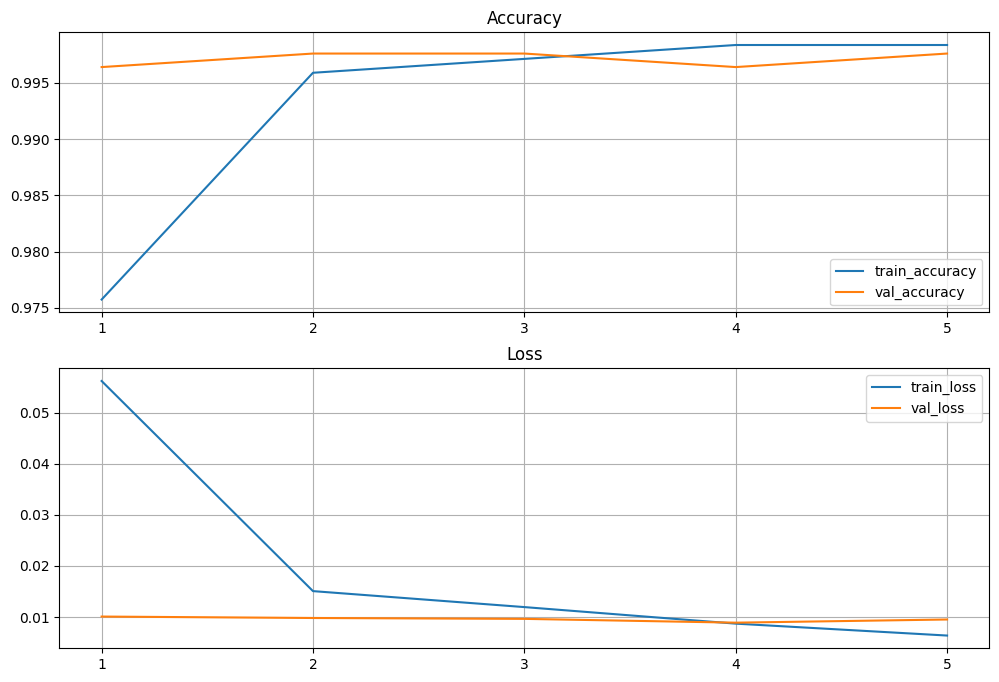

In [43]:
# The final metrics on train- and validation-set

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

epochs = np.arange(1, n_epochs + 1)

ax[0].plot(epochs, history["accuracy"], label="train_accuracy")
ax[0].plot(epochs, history["val_accuracy"], label="val_accuracy")
ax[0].set_xticks(epochs)
ax[0].legend(); ax[0].grid(); ax[0].set_title("Accuracy")

ax[1].plot(epochs, history["loss"], label="train_loss")
ax[1].plot(epochs, history["val_loss"], label="val_loss")
ax[1].set_xticks(epochs)
ax[1].legend(); ax[1].grid(); ax[1].set_title("Loss")

plt.show()

In [44]:
# Metrics on Test-set (looks pretty good)
test_history

{'loss': [0.00899179898148689], 'accuracy': [0.9975961538461539]}

Now that the final model is trained, it will be used for doing predictions.

Batch:
images:  torch.Size([64, 3, 224, 224])
labels:  torch.Size([64])


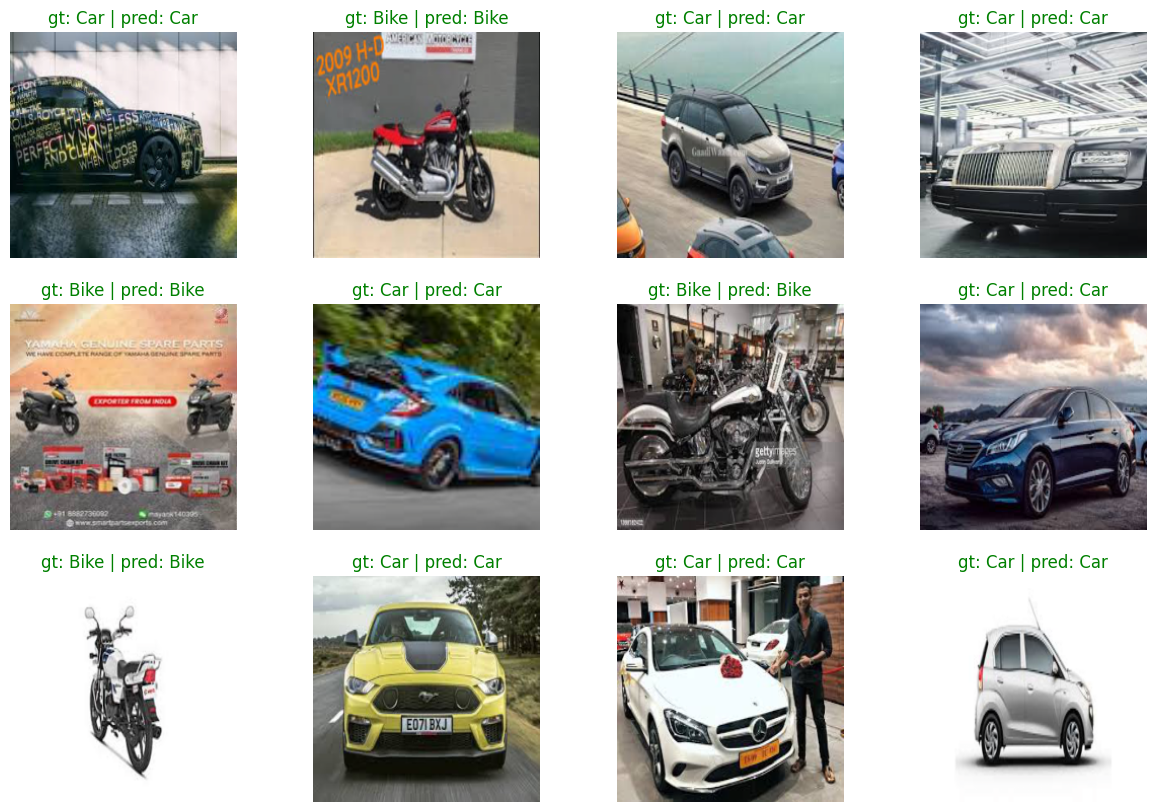

In [48]:
samples = next(iter(test_loader))
images, labels = samples

print("Batch:")
print("images: ", images.shape)
print("labels: ", labels.shape)

# Parameter to invert the normalization of the input data
normalized = True

fig, ax = plt.subplots(3, 4, figsize=(15, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i, ax in enumerate(ax.flat):
    pred, feats = model_final(images[i].unsqueeze(0).to(device))
    pred = int(torch.round(pred).item())
    image = inv_normalize(images[i].squeeze()).permute(1, 2, 0).numpy()
    label = labels[i].item()

    ax.imshow(image)
    txt_color = "green" if label == pred else "red"

    ax.set_title(f"gt: {lbl_mapping[labels[i].item()]} | pred: {lbl_mapping[pred]}",
                 color=txt_color)
    ax.axis('off')
plt.show()